In [2]:
import numpy as np
import scipy.io as sio
from lib import view, traj_view
import matplotlib.pyplot as plt
from IPython.display import Image
import json as json 
from elements import ELEMENTS

![title](ML2.png)


Block in which we give a bit of context on the importance of materials prediction starting from their atoms, and how, in order to achieve an accurate number, very expensive calculations are needed.

The definition of a macroscopic property of an assembly of atoms can be made easier by considering a fewer number of atoms instead of $10^{23}\; / cm ^3\; * A_{needed}$  in case one can define repeating units.

Materials which atoms are organized in a perfectly ordered repetition of smaller units are called crystals.
In this notebook you will study the properties of a collection of crystalline materials composed of a wide variety of elements, and see how just by changing their constituents arrangements and their chemistry, one can create materials with very different properties.


In [3]:
#FIRST ACT : Loading the structures 
# Let's for first try to make python read our database. Usually, the form of an atomic 
# structure is given in terms of :
# 1. Atom's cartesian positions in 3D ( their x,y and z coordinates)
# 2. Element of the atom ( H, O, Bi ...)
# 3. Dimension of the unit element that needs to be repeate (cell parameter)

## FOR ALLOYS
def parser(d):
    mats=[]
    for mat in d:
        pos=mat['poscar']
        lines=pos.splitlines()
        a=np.array([float(x) for x in lines[2].split()])
        b=np.array([float(x) for x in  lines[3].split()])
        c=np.array([float(x) for x in lines[4].split()])
        species=lines[5].split()
        spe_count=[int(x) for x in lines[6].split()]
        i=8
        p=[]
        mol={'species':[], 'positions':[],'cell':[a,b,c]}
        for j in range(sum(spe_count)):
            mol['positions'].append(sum([float(x)*np.array(mol['cell'][k]) for k,x in enumerate(lines[i+j].split()[:3])]))
            mol['species'].append(ELEMENTS[lines[i+j].split()[3]].number)
        mats.append(mol)
    return mats


In [5]:
### We will save dd in an ase compatible format to make it easier to read it
#rid = pd.read_json('ec.json')
rid = json.load(open('ec.json'))
mats = parser(rid)

In [7]:
##Task number one : Students try to read the xyz file in their possession,here for simplicity parsed in ase
## as a first exercise, they will place the coordinates in position, species in sp and assemble them in a 
## simple dictionary entry called molecule, with two attributes : "pos" and "sp"
mol = mats[-35]
view(mol, (3,3,3))

A Jupyter Widget

A Jupyter Widget

## As a first exercise, they will place the coordinates in position, species in sp and assemble them in a simple dictionary entry called molecule, with two attributes : "pos" and "sp"

In [12]:
# As studied in the introductory part, to build a solid prediction scheme we need to be able to come up 
# with "descriptors" which can distiguish them according to their relevant characteristics e.g. packing, 
# recurrent orientation, particular ratio of a species Vs another etc....
# First One : How can we characterize how "packed" they are? Yes, we are talking about density!



#Try calculating the number of atoms per frame in a variable called Nat

def NumberOfAtoms(mol):
    #Start by the positions vector, and print its length!
    Nat = 1.
    i = 0
    #for at in mol["positions"]:
    #    i+=1
    return Nat

Nat = NumberOfAtoms(mats)

# How do we calculate the volume of a unit cell? 
# We have its "cell" sides..now, do you remember how to calculate
# the volume of a box ? Vol = a*b*c (Let's hope they're all orthorombic)

def Volume(mol,cm=True):
    volume = 1. #to be completed!
    a = mol["cell"][0][0]
    b = mol["cell"][1][1]
    c = mol["cell"][2][2]
    volume = a*b*c ## This will be in Angstrom^3, what if we want it in cm^3?
    if cm==True:
        volume = volume / factor
        #What is the factor we have to divide it by ? Rememeber Angstrom = 0.0000000001 m = 10^-10 m 
    return volume


#Finally, we can print the Density! (atomic)
#Wait a sec, if we want to do a mass density?
nsites=np.array([r["nsites"] for r in rid])
Mv = np.array([r["volume"] for r in rid])/nsites

# Let's count the atoms' masses!
def getMass(mol):
    for i in elems:
        imass = i.umass/Nav # in centigrams, it'll be a small number :)
        totmass += imass
    return mass
#print(Mv)

#mass = getMass(mats)
#density = mass / rid["volume"]

We have an additional information encoded in this databse, one that we are not using : the chemical species involved.
The alloys we are trying to describe seem to be composed of different atomic species, ranging from hydrogen to bismuth!! 
Since we have seen that the resistence of a macroscopic alloy is related to the bonding strength of their atomic constitunts, let's classify each of this alloys depending on the species they contain.
We could do as follows: 
Let's prepare a large array of atoms counters (we would make one column per atomic species), one per alloy. In each of the columns we accumulate the number of occurences of its corresponding atomic species, in the selected frame. 
Let's give an example : 

atomic species : $[nH\,\,\,nO]$

frame : $H_2O$

atomic counter : $[2\,\,\,0]$

Now, let's do this for all the frame in this crystal set, and let's see how many atomic species there are!

![title](PT.png)

In [10]:
## CHEMISTRY BLOCK !
# Students are invited to build a dictionary based on the Periodic Table which associates a key to each *group* 
# This will be used later to build a chemical descriptor.
g_dict = { 
1 : [1,7,8,9,17,35,53], #Non Metals
2 : [3,11,19,37,55],
3 : [4,12,20,38,56],
4 : [13,30,31,48,49,50,80,81,82,83],
5 : [5,14,32,33,51,52], #Non Metals
6 : [6,15,16,34], #Non Metal
7 : [21,22,23,24,25,26,27,28,29,39,40,41,42,43,44,45,46,47,72,73,74,75,76,77,78,79]}


mnm_dict = {
    1 : [1,7,8,9,17,35,53,5,14,32,33,51,52,6,15,16,34],
    2 : [3,11,19,37,55,4,12,20,38,56,13,30,31,48,49,50,80,81,82,83,21,22,23,24,25
         ,26,27,28,29,39,40,41,42,43,44,45,46,47,72,73,74,75,76,77,78,79]
}



In [17]:
# Chemical Descriptor : Part I
# The binning of the number of species
## We have a periodic table, we will ask the students to use it to divide the structures between which atom
## is contained in the non metallic and metallic regions. 
## This will give us an idea of which kind of bonding hey will be able to exhibit.

elem_dict1 = []
for i in [list(set(mat["species"])) for mat in mats]: 
    for j in i:
        if j not in elem_dict1:
            elem_dict1.append(j)
            
elem_dict2=[j for i in [list(set(mat["species"])) for mat in mats] for j in i if j not in elem_dict1 ]

###count the occurencies of z species in each frame i 
z_counter = np.zeros((len(mats),len(elem_dict1))) 
g_counter = np.zeros((len(mats),7))
mnm_counter = np.zeros((len(mats),2))

for j,m in enumerate(mats):
    for i in m["species"] :
        z_counter[j,elem_dict1.index(i)] += 1
        dum=[key for key,values in g_dict.items() if i in values]
        g_counter[j,dum[0]-1]+=1
        dum_2=[key for key,values in mnm_dict.items() if i in values]
        mnm_counter[j,dum_2[0]-1]+=1
vm = np.array([i for i in Mv])




props_g = np.column_stack((vm,g_counter/nsites.reshape((1181,1))))
props_z = np.column_stack((vm,z_counter/nsites.reshape((1181,1))))
props_mnm = np.column_stack((vm,mnm_counter/nsites.reshape((1181,1))))
props_mv = vm

props=props_mnm

## To make our algorithm learn something out of our data we first need to find which samples are going to be used as training points, and which will be left to test the quality of our fit.
### This requires us to "split" the data into two big groups : TRAINING SET and TEST SET.
### The former will be used to find the optimal coefficients to catch the fluctuations of the properties as a function of the chosen features, the latter will be used to get an idea of how general our model will be. 

In [18]:
# TRAIN AND TEST PREPARATION 
# First, create two arrays of indices which will be used to define the train and test sets :
# Wait a minute, how many samples do we have?
X = props

print("Number of samples : ", g_counter.shape[0])
ntot = X.shape[0]

# Choose how many points we want to use to train onto 
ntrain = 900
# Keep in mind they have to be less than the total numnber of points : 
# They can't be more, because we can only train on what we know,
# and can't be all of them, as we wouldn't be able to assess how good we would be doing!
itrain = np.arange(ntot)
np.random.shuffle(itrain)
#If we order them randomly, we can be sure to let everyone have the same probability of being chosen
itest = itrain[ntrain:]
itrain = itrain[:ntrain]

K=np.array([r["K_VRH"] for r in rid])
print(len(itest), len(itrain)) 
mean = np.mean(np.log(K[itrain]))

y = np.log(K)


ym = y - mean


#To make it easier later, can we make a function that gives you a test and training set 
# given a ratio of training over test : 

def GiveMeTrainAndTest(X,y,training_fraction):
    #PUT STUFF IN HERE!
    X_train,y_train,X_test,y_test = [1, 1, 1, 1]
    return X_train,y_train,X_test,y_test



Number of samples :  1181
281 900


In [19]:
### LOSS FUNCTION  : Our algorithm will produce a predicted property that will be as close as possible 
###                  to the one we have originally
### and
### Prediction Machine : It will be a function of our descriptors, and we will get the weights.



def modify_X(Xfull):
    Xnew=Xfull.copy()
    #X_new = np.vstack((np.exp(Xfull[:,0]),Xfull[:,1:]))
    return Xnew

def Prediction(w,X):
    # Linear Model 
    #y_fun = lambda w: 
    if len(w)==1:
        pred = modify_X(X)*w
    else:
        pred = np.dot(modify_X(X),w)
    return pred #y_fun


def LOSS(w,y_true,X):
    ## It will be a Root Mean square Error
    ## Couldn't get the lambda function of a lambda function work
    ## It'd be nice if we could have combined them!
    lossfun = lambda w: np.sqrt(((y_true-np.dot(X,w[:]))**2).mean())
    return np.sqrt(((y_true-Prediction(w,X))**2).mean()) #lossfun 



In [20]:
### Now, finding the weights that allow us to follow our training points requires
### solving an optimization problem, similarly to what you have seen in the introductory part.
### The so called "optimal" weights will be the ones that MINIMIZE a function that measures our
### total error on prediction, called LOSS.

### Since this can be a particularly slow problem to solve, we provide a minimizer that does it for you!
from scipy.optimize import minimize
# Initialize the starting guess for our weights
#w0 = np.random.random(props_mv.shape[1])
w0 = np.random.random(X.shape[1])
# Now we minimize!
solution = minimize(lambda x: LOSS(x,ym,X),w0)
w_opt = solution.x

### If you want to look at how complicated our problem was, you
### can print the output of minimize and see how many iterations it took!
print(solution)



#This is our output
print(w_opt)

      fun: 0.43952322448795544
 hess_inv: array([[ 0.01138603, -0.19893841, -0.20003082],
       [-0.19893841,  8.24975206,  2.91103757],
       [-0.20003082,  2.91103757,  4.22287591]])
      jac: array([ -1.12876296e-06,   3.72529030e-09,  -8.56816769e-08])
  message: 'Optimization terminated successfully.'
     nfev: 70
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([-0.08216418,  1.2376951 ,  1.47789364])
[-0.08216418  1.2376951   1.47789364]


In [27]:
from sklearn.metrics import r2_score, mean_squared_error


##Create train / test
db_X_train = modify_X(props[itrain,:])
db_X_test = modify_X(props[itest,:])

db_y_train = ym[itrain]
db_y_test  = ym[itest]

# Create linear regression object
w0 = np.random.random(props.shape[1])
# Now we minimize!
solution = minimize(lambda x: LOSS(x,db_y_train,db_X_train),w0)
w_opt = solution.x


# Make predictions using the testing set
db_y_pred = np.dot(db_X_test,w_opt)


# The coefficients
print('Coefficients w*: ', solution.x)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(db_y_test, db_y_pred))

check = 210
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(db_y_test, db_y_pred))
avg_err = []
for i in range(len(itest)):
    avg_err.append(int(np.abs(np.exp(db_y_pred[check]+mean)- K[itest[check]])/K[itest[check]]*100))
print("Average error: ", np.mean(avg_err),"%")


    

print("Predicted : ",np.exp(db_y_pred[check]+mean))
print("Actual :", K[itest[check]])
#print("Error percentage on test: ", int(np.abs(np.exp(db_y_linear[check]+mean)- rid["K_VRH"][itest[check]])/rid["K_VRH"][itest[check]]*100),"%")


Coefficients w*:  [-0.08143762  1.23739094  1.47728454]
Mean squared error: 0.20
Variance score: 0.51
Average error:  10.0 %
Predicted :  127.634613561
Actual : 115.217535805


In [30]:
#How does the training set choice affect the erorr? 
#Have you noticed that you can have very different performances by increasing the training set?
#Let's be quantitative about it: if the error goes down as we increase the training points, it means
#that our algorith is learning as much as it can from its data.
#To measure this trend, people often trace a plot called "learning curve" 
#We take a bunch of points out of our data, and use them as fixed test set. (It'll be important to choose it wisely)
#Then we take the remaning points, and use incrasing chunks of them to perform an increasingly informed regression.
#If the training adds information, the error will decrease as we enlarge the training set.

r2scores = []
RMSEtrain = []
RMSEtest = []

allidx = np.arange(ntot)
np.random.shuffle(itrain)
train  = allidx[:1000]
itest   = allidx[1000:]

for i in [10,50,100,500,900]:
    ntrain = i
    itrain = train[:ntrain]
    print(i)
    #mean = np.mean(np.log(rid["K_VRH"]))
    mean = np.mean(K[itrain])
    #y = np.log(rid["K_VRH"])
    y = K

    ym = y - mean

    db_X_train = props[itrain,:]
    db_X_test = props[itest,:]

    db_y_train = ym[itrain]
    db_y_test  = ym[itest]


    w0 = np.random.random(props.shape[1])
    #print(w0.shape)
    #print(db_X_train.shape,db_y_train)
    # Now we minimize!
    solution = minimize(lambda x: LOSS(x,db_y_train,db_X_train),w0)
    w_opt = solution.x

    db_y_linear = np.dot(props,w_opt)

    # The coefficients
    #print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
         % solution.fun)
    # Explained variance score: 1 is perfect prediction
    RMSEtrain.append(mean_squared_error(db_y_train, db_y_linear[itrain]))
    RMSEtest.append(mean_squared_error(db_y_test, db_y_linear[itest]))
    #print('Variance score: %.2f' % r2_score(db_y_test, db_y_pred))
    print('Variance score: %.2f' % r2_score(db_y_test, db_y_linear[itest]))
    r2scores.append(r2_score(db_y_test, db_y_linear[itest]))
    #print(" SCIKIT :", np.exp(db_y_pred[12]),rid["K_VRH"][itest[12]])
    print(" T-BOAT :",db_y_linear[itest[12]]+mean,K[itest[12]])
    

10
Mean squared error: 65.73
Variance score: -0.30
 T-BOAT : 284.886796934 117.410033376
50
Mean squared error: 55.12
Variance score: 0.28
 T-BOAT : 208.516917456 117.410033376
100
Mean squared error: 54.53
Variance score: 0.28
 T-BOAT : 204.108201542 117.410033376
500
Mean squared error: 56.89
Variance score: 0.35
 T-BOAT : 185.691707335 117.410033376
900
Mean squared error: 55.57
Variance score: 0.36
 T-BOAT : 175.732122472 117.410033376


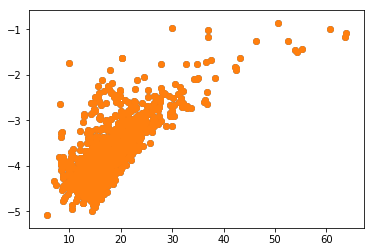

In [32]:
plt.scatter(props[:,0],1-np.log(K))
plt.show()

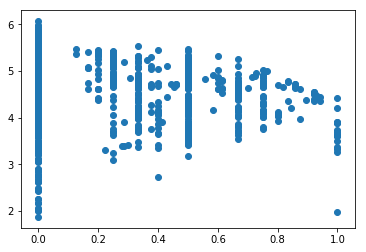

In [505]:
#10^(slope*log(X))
K = (rid["K_VRH"])
plt.scatter(props_g[:,4],np.log(K))
#plt.scatter(props_g[:,4],K)


#plt.scatter(props_g[:,0],np.log(K))

In [532]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import itertools
%matplotlib notebook

<IPython.core.display.Javascript object>


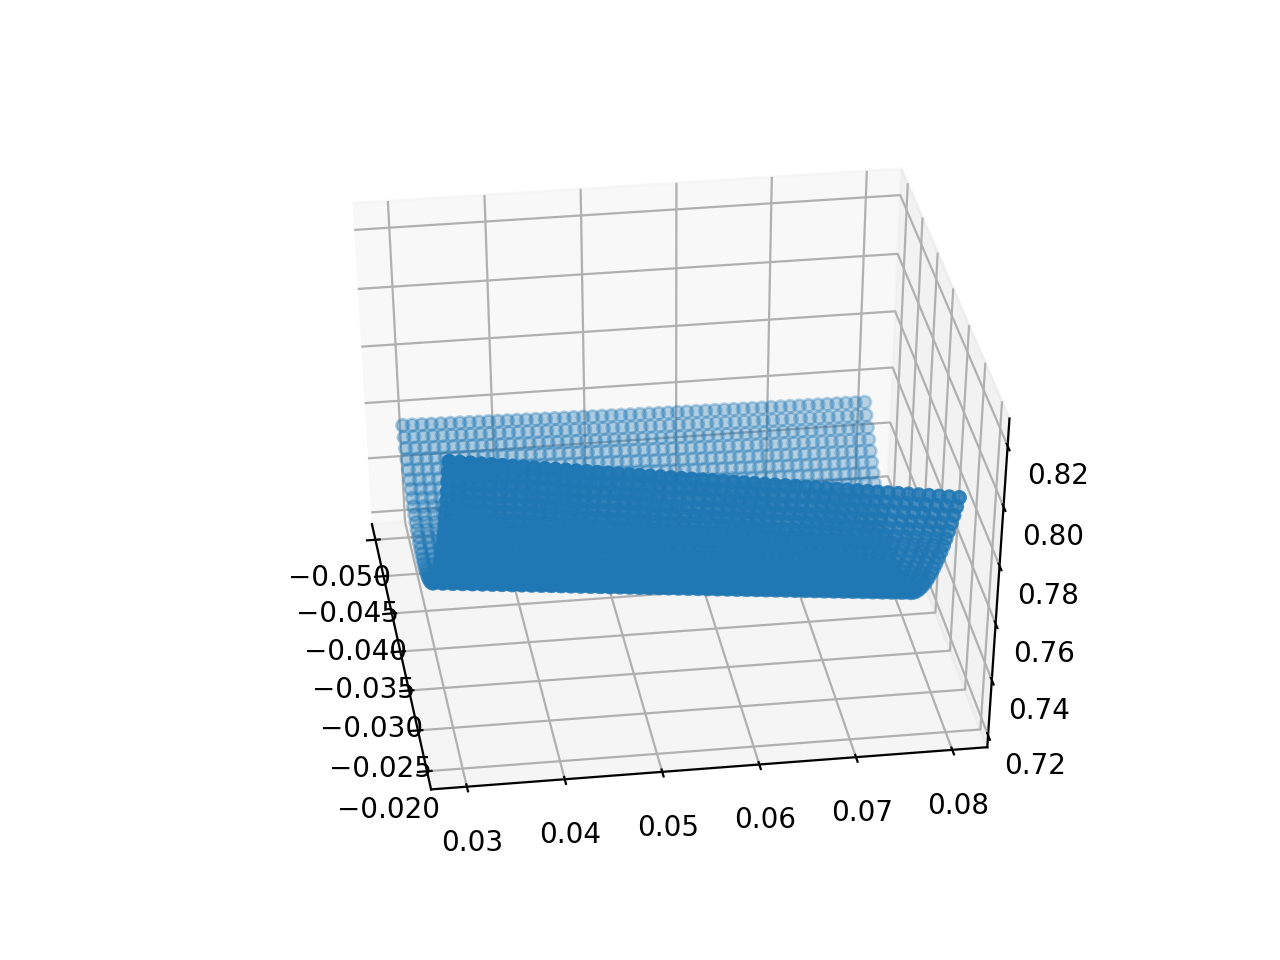

In [535]:
cmap=plt.cm.rainbow
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
w1=np.linspace(-0.05, -0.02, 50)
w2=np.linspace(0.03, 0.08, 50)
ax.scatter([a1 for a1,a2 in itertools.product(w1, w2)], [a2 for a1,a2 in itertools.product(w1, w2)], 
           [ LOSS( np.array([a1,a2, 1-a2]) ,db_y_train_lin ,db_X_train ) for a1,a2 in itertools.product(w1, w2)] )
plt.show()

In [527]:
blah=[ LOSS( np.array([a1,a2, 1-a2]) ,db_y_train_lin ,db_X_train ) for a1,a2 in itertools.product(w1, w2)]

In [536]:
def costNd(a,x, y):
    yn=sum(ai*xi for ai, xi in zip(a,x))
    return np.sum((y-yn)**2)

def best_slopeND(alist,x,y):
    lowestcost=costNd(alist[:,0],x,y)
    best=alist[:,0]
    for ax in itertools.product(*alist):
            c=costNd(ax, x,y)
            if c< lowestcost:
                lowestcost=c
                best=ax
    return best
def DaND(rng, N):
    return [abs(r[1]-r[0])/N for r in rng]
def simple_lregND(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(DaND(rng,N)) > thr:
        alist=np.array([np.linspace(r[0],r[1],N) for r in rng])
        ba=best_slopeND(alist,x,y)
        count+=N**len(alist)
        rng=[[b-D,b+D] for b,D in zip(ba, DaND(rng,N)) ]
    print("after trying ",count," slopes")
    return ba, count

In [553]:
simple_lregND(db_X_train.T,db_y_train_lin,1e-8,[[-10,10],[-10,10],[-10,10]],5)

after trying  2750  slopes


((-1.259510299505459, -3.3333333626536437, 11.66666663734636), 2750)

In [642]:
print(itrain)

[ 757  494  436  170  223  209  456 1013 1097  988 1164  338 1053  562
  344  398 1050  878  418  916  639  799  376  324  983 1178  818  968
  431    6  905 1068  555   85  245  268  147  440  404  766  111  689
    3  238  309  676 1021  114  198  551   13  999  765  495  422 1024
  529  633  288  726 1165  377  274  963  693   41  421  188 1076 1151
    5  872  662  290 1152  752  902  579  628  711   53 1065   99  944
 1063   66 1180 1172  219   33  896  400  796 1027   37  608  929  300
  284  389  292  109  775 1075  750  884  528  186  784  395  617 1051
  616  524 1146   92  516  611 1070  531 1133 1174 1077  283  687  293
  552  675  317  601  129  137  133   81  935  655  234  236   31   60
  594   25  411 1060  365  630  401  984  190  166  585  451  281  143
  698  388  749  899  906  375  218   14  394  699  266  648 1119  135
  754  973 1129  690 1057  369  215 1087  287  261  571  493   48    2
  286  862  193 1108  379   98  827  723  820  506 1084 1124  163  595
  759 